In [1]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

In [2]:
def filter1(image, median_size=3, gaussian_sigma=1):
    image = cv2.medianBlur(image, median_size)
    image = cv2.GaussianBlur(image, (0, 0), gaussian_sigma)
    return image

def filter2(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.bilateralFilter(image, 9, 75, 75)
    return image

def filter3(image, median_size=3):
    image = cv2.medianBlur(image, median_size)
    image = cv2.fastNlMeansDenoisingColored(image)
    return image

In [3]:
# Splits the given rect in 4 rect if there are at least k points inside 
def split_rect(rect, points, k=5, max_depth=5):
    # Rect is a tuple of 4 points
    # rect = (upper_right, upper_left, lower_left, lower_right)
    max_depth -= 1
    if max_depth == 0:
        return []
    rects = []
    
    y_min, y_max = rect[3][1], rect[0][1]
    x_min, x_max = rect[1][0], rect[0][0]
    y_med, x_med = (y_max + y_min)/2, (x_max + x_min)/2
    
    inside_points = [p for p in points if p[0] >= x_min and p[0] <= x_max and p[1] >= y_min and p[1] <= y_max]
    if len(inside_points) > k:
        upper_right_rect = ((x_max, y_max), (x_med, y_max), (x_med, y_med), (x_max, y_med))
        upper_left_rect = ((x_med, y_max), (x_min, y_max), (x_min, y_med), (x_med, y_med))
        lower_left_rect = ((x_med, y_med), (x_min, y_med), (x_min, y_min), (x_med, y_min))
        lower_right_rect = ((x_max, y_med), (x_med, y_med), (x_med, y_min), ((x_max, y_min)))
                
        upper_right_split = split_rect(upper_right_rect, points, k, max_depth)
        upper_left_split = split_rect(upper_left_rect, points, k, max_depth)
        lower_left_split = split_rect(lower_left_rect, points, k, max_depth)
        lower_right_split = split_rect(lower_right_rect, points, k, max_depth)
        
        if len(upper_right_split) > 0:
            rects += upper_right_split
        else:
            rects += [upper_right_rect]
            
        if len(upper_left_split) > 0:
            rects += upper_left_split
        else:
            rects += [upper_left_rect]
            
        if len(lower_left_split) > 0:
            rects += lower_left_split
        else:
            rects += [lower_left_rect]
            
        if len(lower_right_split) > 0:
            rects += lower_right_split
        else:
            rects += [lower_right_rect]
         
            
    return rects

In [4]:
def getDensity(matched_kp:list[tuple[float, float]], template_partition:list):
    match_count = { s: 0 for s in template_partition }
    
    for x_kp, y_kp in matched_kp:
        for section in template_partition:
            (x_max, y_max), (_, _), (x_min, y_min), (_, _) = section
            if (x_min <= x_kp <= x_max) and (y_min <= y_kp <= y_max):
                match_count[section] += 1

    return [s for s in template_partition if match_count[s] > 0]
    # return sum([1 for s in template_partition if match_count[s] > 0]) / len(template_partition)

In [5]:
template = cv2.imread("./dataset/models/ref1.png")
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)

scene = cv2.imread("./dataset/scenes/scene2.png")
scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)
scene = filter1(scene)

In [6]:
sift = cv2.xfeatures2d.SIFT_create()

kp_template = sift.detect(template)
kp_template, desc_template = sift.compute(template, kp_template)

kp_scene = sift.detect(scene)
kp_scene, desc_scene = sift.compute(scene, kp_scene)


FLANN_INDEX_KDTREE = 1

flann = cv2.FlannBasedMatcher(
    indexParams = { "algorithm": FLANN_INDEX_KDTREE, "trees": 5 },
    searchParams = { "checks": 50 }
)
matches = flann.knnMatch(desc_template, desc_scene, k=2)
good_matches = [ m for m, n in matches if m.distance < 0.7*n.distance ]

template_pts = np.float32([ kp_template[m.queryIdx].pt for m in good_matches ]).reshape(-1, 2)
scene_pts = np.float32([ kp_scene[m.trainIdx].pt for m in good_matches ]).reshape(-1, 2)

[ WARN:0@0.599] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


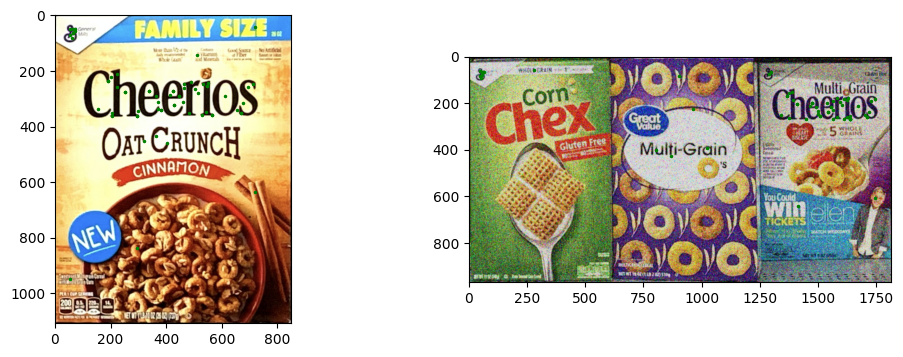

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow(template)
plt.plot(template_pts[:, 0], template_pts[:, 1], "g.", markersize=3)

plt.subplot(1, 2, 2)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)
plt.show()

In [8]:
w, h, _ = template.shape
rects = split_rect(
    ( (h, w), (0, w), (0, 0), (h, 0) ),
    [ (kp.pt[0], kp.pt[1]) for kp in kp_template ],
    k = 5,
    max_depth = 4
)

match_rects = getDensity(template_pts, rects)

print(f"Confidence: {len(match_rects) / len(rects)}")

Confidence: 0.28125


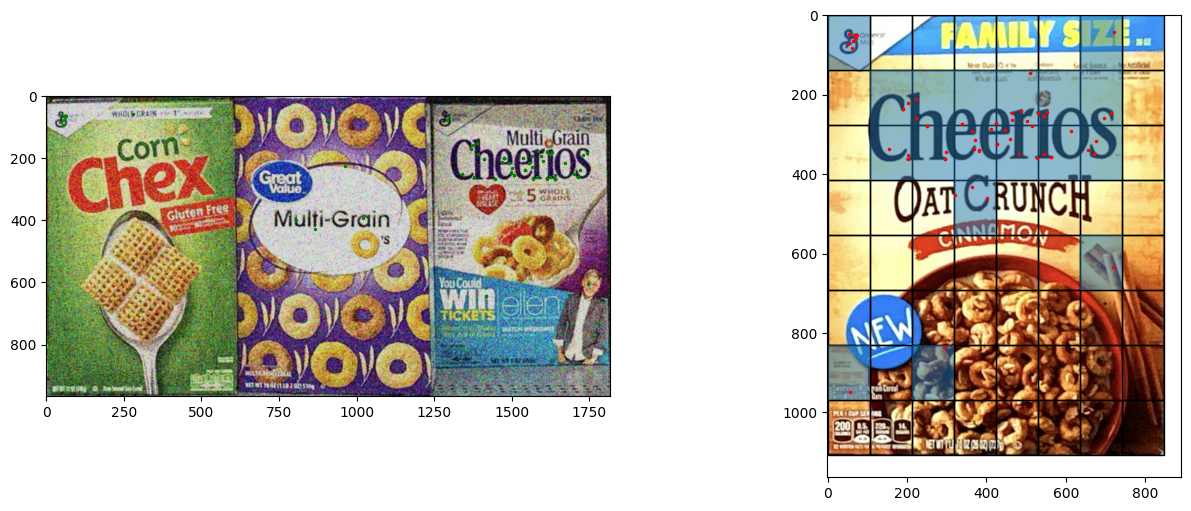

In [9]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.imshow(scene)
plt.plot(scene_pts[:, 0], scene_pts[:, 1], "g.", markersize=3)

ax = plt.subplot(1, 2, 2)
ax.imshow(template)
# ax.plot([kp.pt[0] for kp in kp_template], [kp.pt[1] for kp in kp_template], ".")
ax.plot([kp[0] for kp in template_pts], [kp[1] for kp in template_pts], "r.", markersize=3)
for r in rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=False))
for r in match_rects:
    ax.add_patch(Rectangle(r[2], r[0][0] - r[1][0], r[0][1] - r[3][1], fill=True, alpha=0.5))

plt.show()